# Portfolio Optimization
**Portfolio optimization** is the decade-old mathematical practise of experimenting with different weight allocations over $N$ different asets to create a combination that minimizes risk while maximizing returns. 

In this notebook, I take a closer look at the **mean-variance portfolio (MVP)** proposed by Markowitz in 1952, and the different ways it can be improved. 

Before diving into the code, please consult the read.me document for information regarding limitations, assumptions and more.

Be aware of the results from the proposed models: they should not be seen as financial advice.

In [36]:
# Import libraries
import numpy as np
import pandas as pd
import cvxpy as cp # library for convex optimization problems

import os

from datetime import datetime
import pandas_market_calendars as mcal # library for market calendars

import matplotlib.pyplot as plt

In [37]:
# Initialize global variables
# Load data
opt_dates = os.listdir("assets")
historical_data = pd.read_csv("historical_data.csv").set_index("Date")
historical_data = historical_data.dropna(axis=1, how='any')

# Indexes for iteration
start_idx = 0
end_idx = 25 #len(opt_dates)
lookback = 756

# Memories 
all_w = {}
all_rets = {}

# Obtain formatted dates
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule('2000-01-01','2030-01-01')
trading_days = schedule.index

all_dates = list(historical_data.index)
all_dates = [ int(datetime.strptime(x, '%Y-%m-%d').strftime('%Y%m%d')) for x in all_dates ]

## Portfolio Optimization Functions

### **Mean-Variance Portfolio (MVP)**
The MVP maximizes $w$ in: $$w’ \mu - \frac{\lambda}{2}w’ \sum w$$ subject to $1’w=1$ and $w \ge 0$, where $\mu$ is the expected returns, $\sum$ is the covariance matrix, and $\lambda$ is a hyper-parameter that controls how risk averse the investor is. 

In [38]:
# Function for optimizing weights given any estimator for mu and sigma
def design_MVP(mu, sigma, lmd):
    # Initialize variables and constraints
    N = len(sigma)
    weights = cp.Variable(N) # Vector variable "weights" of size N that will be optimized using train data. 
    constraints = [cp.sum(weights) == 1, weights >= 0] # Define capital budget, and long-only constraint

    prob = cp.Problem(cp.Maximize(mu @ weights - (lmd/2) * cp.quad_form(weights, sigma)), constraints) # Form the problem (formula above)
    prob.solve() # Find the optimal value of the problem above 
    return weights.value # Return a vector containing optimal weight allocations across the N assets

In [39]:
# MVP function using Gaussian estimators
def gaus_MVP(X_lin, lmd=1):
    X_log = np.log1p(X_lin)
    
    # Estimate mu and Sigma with training data
    mu = X_log.mean().values
    sigma = X_log.cov().values

    return design_MVP(mu, sigma, lmd)

Instead of having a fixed $\lambda$, we could use cross-validation within the in-sample data to determine it based on Sharpe ratio, making the MVP more adaptable in volatile periods. 

In [40]:
# Function for cross-validating lambda in MVP
def estimate_lmd(X_lin, lambdas):
    lmd_performance = {}
    
    # Split in-sample data in 70-30 train data and validation data
    T = X_lin.shape[0]
    T_split = round(0.70*T)

    X_lin_trn = X_lin[:T_split]
    X_lin_val =  X_lin[T_split:]

    # Compute weights and returns for each lambda
    for lmd in lambdas:
        w_MVP = gaus_MVP(X_lin_trn, lmd)
        ret_MVP = X_lin_val @ w_MVP

        # Measure performance based on Sharpe ratio
        sharpe_ratio = ret_MVP.mean() / (ret_MVP.std() + 1e-8)
        lmd_performance[lmd] = sharpe_ratio

    # Use the lambda with the highest Sharpe ratio
    best_lmd = max(lmd_performance, key=lmd_performance.get)
    print(f"The best lambda value is {best_lmd} with a Sharpe ratio of {lmd_performance[best_lmd]}")
    return best_lmd

In [41]:
# MVP function with cross-validation for lambda
def MVP_blmd(X_lin):
    # Estimate lambda using cross-validation 
    print("Cross-validating lambda based on Sharpe ratio...")
    lambdas = np.linspace(1, 64, 25)
    best_lmd = estimate_lmd(X_lin, lambdas)
    weights = gaus_MVP(X_lin, best_lmd)

    return weights

### **Equally Weighted Portfolio (EWP)**
The EWP portfolio is a well-known heuristic portfolio that allocates the capital equal over the $N$ assets, such that: $$w=\frac{1}{N} \times 1$$
In this context, it will be used as a benchmark.

In [42]:
# Equally Weighted Portfolio function
def EWP(X_lin):
    N = X_lin.shape[1]
    return np.repeat(1/N, N)

## Walk-forward Backtesting
Instead of dividing the historical data into the classic in-sample and out-sample dataset, the data is divided into dynamic training windows that each reoptimize the portfolio as new data becomes available. This is known as the walk-forward backtest, and effectively mimicks the way it would be done in live trading. 

In [43]:
# Function that finds the lookback day necessary for the in-sample dataset window   
def shift_trading_days(start_date, lookback=252):
    start_date = pd.Timestamp(start_date)
    idx = trading_days.get_loc(start_date)
    return trading_days[idx - lookback]

In [44]:
# Function for backtesting the vanilla MVP 
def backtest(portf_funcs, prices: pd.DataFrame, str_test: str, end_test: str, lookback: int=252, rebalance: int=1, cost_bps: int=0):
    # Calculate linear and logarithmic returns; Remove NaN to prevent errors
    X_lin = prices.pct_change().dropna()

    # Define train and test data
    lkback_date = shift_trading_days(str_test, lookback)
    X_lin_test =  X_lin[str_test:end_test]
    X_lin_trn = X_lin[str(lkback_date):str_test]

    portf_rets = {}
    portf_ws = {}

    for portf_name, portf_func in portf_funcs.items():
        print(f"\nCommencing backtest for {portf_name}...")
        # Initialize variables
        N = X_lin.shape[1] 
        current_w = np.repeat(0, N) 
        portf_w = pd.DataFrame(index=X_lin.index, columns=X_lin.columns) 
        portf_ret = pd.Series(index=X_lin.index)

        # Design portfolio weights
        print("Designing weights...")
        og_w = portf_func(X_lin_trn)

        # Backtest portfolio day-to-day with test data
        print("Computing returns...")
        for t_idx, t in enumerate(X_lin_test.index):
            # Store weights
            trans_costs = 0.0
            if t_idx == 0 or t_idx % rebalance == 0:
                turnover = np.abs(og_w - current_w).sum()
                trans_costs = turnover * cost_bps / 1e4
                current_w = og_w
            portf_w.loc[t] = current_w

            # Compute portfolio return
            period_ret = X_lin_test.loc[t] @ current_w
            portf_ret.loc[t] = period_ret - trans_costs

            # Normalize weights based on asset performance to simulate weight drift
            current_w = current_w * (1 + X_lin_test.loc[t])
            current_w = current_w / current_w.sum()

        # Save returns and weights to each portfolio function
        portf_rets[portf_name] = portf_ret.dropna()
        portf_ws[portf_name] = portf_w.dropna(how="all")

    return portf_rets, portf_ws


In [45]:
# Include portfolio functions for testing 
portf_funcs = {"Vanilla MVP":MVP_blmd,
               "EWP": EWP}
for portf in portf_funcs:
    all_w[portf] = pd.DataFrame()
    all_rets[portf] = pd.Series()

# Will cycle through the monthly constituents and backtest the portfolios with the available data
while start_idx < end_idx:
    # Load constituents and save ones we have price data for as "exst_consts"
    consts = pd.read_csv("assets\\" + opt_dates[start_idx]).set_index("rank")
    exst_consts = set(consts["ticker"]).intersection(historical_data.columns)
    exst_consts = historical_data[list(exst_consts)]

    # Obtain the train + test data by period
    str_test = datetime.strptime(opt_dates[start_idx][6:-4], '%Y%m%d').strftime('%Y-%m-%d')
    end_test = datetime.strptime(str(int(opt_dates[start_idx + 1][6:-4]) - 1), '%Y%m%d').strftime('%Y-%m-%d') 
    exst_data = exst_consts.loc[:end_test]

    # Conduct backtest with weekly rebalancing and transaction costs of 0.30% per trade
    print(f"Running backtest {start_idx}. Reoptimization as of: {str_test}")
    portf_ret, portf_w = backtest(portf_funcs, exst_data, str_test, end_test, lookback, 5, 30)
    print("Backtesting completed \n")
    
    # Concatenate returns and weights to previous period
    for portf in portf_funcs:
        all_rets[portf] = pd.concat([all_rets[portf], portf_ret[portf]])
        all_w[portf] = pd.concat([all_w[portf], portf_w[portf]])

    start_idx += 1

Running backtest 0. Reoptimization as of: 2009-01-30

Commencing backtest for Vanilla MVP...
Designing weights...
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 64.0 with a Sharpe ratio of -0.022724358990341708
Computing returns...

Commencing backtest for EWP...
Designing weights...
Computing returns...
Backtesting completed 

Running backtest 1. Reoptimization as of: 2009-02-27

Commencing backtest for Vanilla MVP...
Designing weights...
Cross-validating lambda based on Sharpe ratio...


C:\Users\vladp\AppData\Local\Temp\ipykernel_22896\1545820923.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_rets[portf] = pd.concat([all_rets[portf], portf_ret[portf]])
C:\Users\vladp\AppData\Local\Temp\ipykernel_22896\1545820923.py:27: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_rets[portf] = pd.concat([all_rets[portf], portf_ret[portf]])


The best lambda value is 1.0 with a Sharpe ratio of -0.014226879822233026
Computing returns...

Commencing backtest for EWP...
Designing weights...
Computing returns...
Backtesting completed 

Running backtest 2. Reoptimization as of: 2009-03-31

Commencing backtest for Vanilla MVP...
Designing weights...
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 1.0 with a Sharpe ratio of -0.014198444262545481
Computing returns...

Commencing backtest for EWP...
Designing weights...
Computing returns...
Backtesting completed 

Running backtest 3. Reoptimization as of: 2009-04-30

Commencing backtest for Vanilla MVP...
Designing weights...
Cross-validating lambda based on Sharpe ratio...
The best lambda value is 1.0 with a Sharpe ratio of -0.02041873059409513
Computing returns...

Commencing backtest for EWP...
Designing weights...
Computing returns...
Backtesting completed 

Running backtest 4. Reoptimization as of: 2009-05-29

Commencing backtest for Vanilla MVP...
Des

## Performance Measures
Below we asses the performance of our portfolios by:
- Cumulative returns
- Drawdown
- Annualized return
- Annualized volatility
- Annualized Sharpe
- Maximum drawdown

In [53]:
# Function for plotting cumulative returns
def plot_cum_rets(all_rets):
    plt.figure(figsize=(12, 6))
    for portf_name in all_rets:
        cum_ret = (1 + all_rets[portf_name]).cumprod() - 1
        cum_ret.plot(label=portf_name, linewidth=1)
    plt.title('Cumulative returns')
    plt.legend(title='Portfolios')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# Function for plotting drawdown
def drawdown(all_rets):
    plt.figure(figsize=(12, 6))
    for portf_name in all_rets:
        cum_ret = (1 + all_rets[portf_name]).cumprod()
        run_max = cum_ret.cummax()
        drawdowns = (cum_ret - run_max) / run_max
        drawdowns.plot(label=portf_name, linewidth=1)
    plt.title('Drawdown')
    plt.legend(title='Portfolios')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [48]:
# Function for calculating maximum drawdown
def max_drawdown(portf_ret):
    cum_ret = (1 + portf_ret).cumprod()
    run_max = cum_ret.cummax()
    drawdowns = (cum_ret - run_max) / run_max
    max_dd = drawdowns.min()
    return max_dd

In [ ]:
# Function for computing annualized returns, volatility and Sharpe ratio
def metrics_table(all_rets, rfr=0.0):
    d_rfr = rfr / 252 # Daily risk-free rate
    performance_table = pd.DataFrame(columns = ["Annualized Return", "Annualized Volatility", "Sharpe Ratio", "Max Drawdown"])
    
    for idx, portf_name in enumerate(all_rets):
        # Calculate annualized returns 
        T = all_rets[portf_name].shape[0]
        annual_ret = (1 + all_rets[portf_name]).prod() ** (252 / T) - 1

        # Calculate annualized volatility
        annual_vol = all_rets[portf_name].std() * np.sqrt(252)

        # Calculate annualized Sharpe ratio
        annual_sharpe = (annual_ret - d_rfr) / annual_vol
    
        # Calculate maximum drawdown
        max_dd = max_drawdown(all_rets[portf_name])

        # Add metrics to table
        performance_table.loc[idx] = [annual_ret, annual_vol, annual_sharpe, max_dd]
    
    performance_table.index = all_rets.keys()
    display(performance_table)

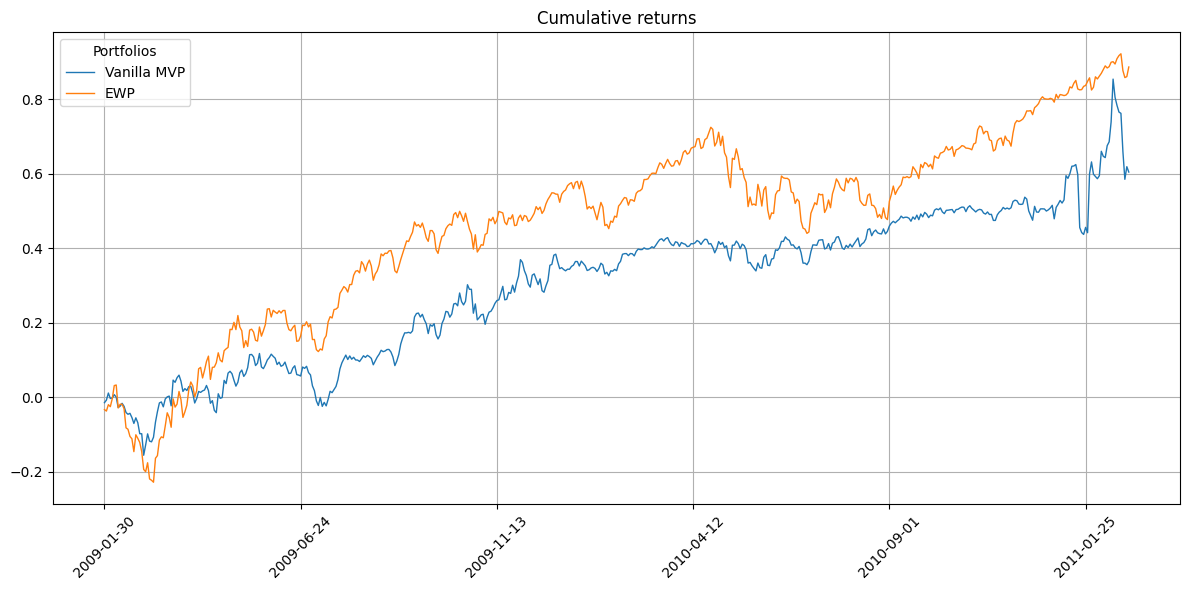

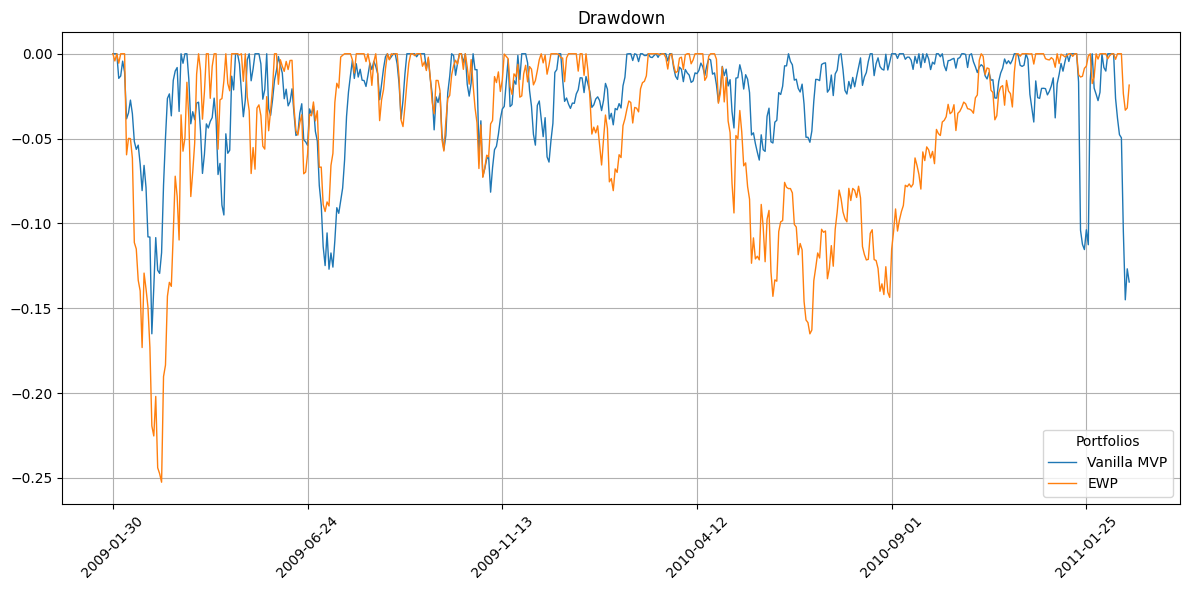

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Vanilla MVP,0.255903,0.242293,1.056170,-0.165087
EWP,0.357806,0.260497,1.373552,-0.252584


In [57]:
# Run all performance measure computations
plot_cum_rets(all_rets)
drawdown(all_rets)
metrics_table(all_rets, rfr=0.0)